# COVID 19 Data Analysis

In response to the COVID-19 pandemic, the White House and a coalition of leading research groups have prepared the COVID-19 Open Research Dataset (CORD-19). CORD-19 is a resource of over 45,000 scholarly articles, including over 33,000 with full text, about COVID-19, SARS-CoV-2, and related coronaviruses. This freely available dataset is provided to the global research community to apply recent advances in natural language processing and other AI techniques to generate new insights in support of the ongoing fight against this infectious disease. There is a growing urgency for these approaches because of the rapid acceleration in new coronavirus literature, making it difficult for the medical research community to keep up.

In [1]:
import pandas as pd
import os
import json
import re
import matplotlib.pyplot as plt
from matplotlib import style
import numpy as np
import nltk
from nltk.corpus import stopwords
from wordcloud import WordCloud, STOPWORDS

style.use("ggplot")

## First extract the data and combine:

The data is mainly in json format. We will convert it into a pandas data frame.
#### Iterate over every json file in the folder and append it to one list, consisting of title, abstract and full text

In [2]:
dirs = ["biorxiv_medrxiv", "noncomm_use_subset", "comm_use_subset"]

docs = []

for d in dirs:
    for file in os.listdir(f"{d}/{d}"):
        file_path = f"{d}/{d}/{file}"
        j = json.load(open(file_path, "rb"))
            
        title = j["metadata"]["title"]
        
        try:
            abstract = j["abstract"][0]
        except:
            abstract = ""
        
        full_text = ""
        for text in j["body_text"]:
            full_text += text["text"] + "\n\n"
            
        docs.append([title, abstract, full_text, d])
        

#### Convert to pandas DataFrame

In [3]:
df = pd.DataFrame(docs, columns = ["title", "abstract", "full_text", "article type"])
df.head()

,title,abstract,full_text,article type
0,The RNA pseudoknots in foot-and-mouth disease ...,{'text': 'word count: 194 22 Text word count: ...,"VP3, and VP0 (which is further processed to VP...",biorxiv_medrxiv
1,Analysis Title: Regaining perspective on SARS-...,"{'text': 'During the past three months, a new ...","In December 2019, a novel coronavirus, SARS-Co...",biorxiv_medrxiv
2,Healthcare-resource-adjusted vulnerabilities t...,,The 2019-nCoV epidemic has spread across China...,biorxiv_medrxiv
3,"Real-time, MinION-based, amplicon sequencing f...",{'text': 'Infectious bronchitis (IB) causes si...,"Infectious bronchitis (IB), which is caused by...",biorxiv_medrxiv
4,A Combined Evidence Approach to Prioritize Nip...,{'text': 'Nipah Virus (NiV) came into limeligh...,Nipah is an infectious negative-sense single-s...,biorxiv_medrxiv


## 1. Overview

#### Let us first get a rough overview over the data we have:

In [4]:
df.shape

(12718, 4)

In [5]:
df.isna().sum()

title           0
abstract        0
full_text       0
article type    0
dtype: int64

##### There doesn't seem to be any na values. Lets make sure:

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12718 entries, 0 to 12717
Data columns (total 4 columns):
title           12718 non-null object
abstract        12718 non-null object
full_text       12718 non-null object
article type    12718 non-null object
dtypes: object(4)
memory usage: 397.5+ KB


In [7]:
df.describe()

,title,abstract,full_text,article type
count,12718,12718,12718,12718
unique,11691,10787,12526,3
top,,,Coronaviruses are a group of enveloped viruses...,comm_use_subset
freq,665,1724,3,9315


##### Though we have no na objects we still have articles without a title or abstract. That is because earlyer we filled in title and abstract with a space when there where none.  It also looks like we have some duplicates. That shouldn't matter too much though. Especially since the maximal reoccurance is 3.

##### Let's take a closer look at the article type distribution:

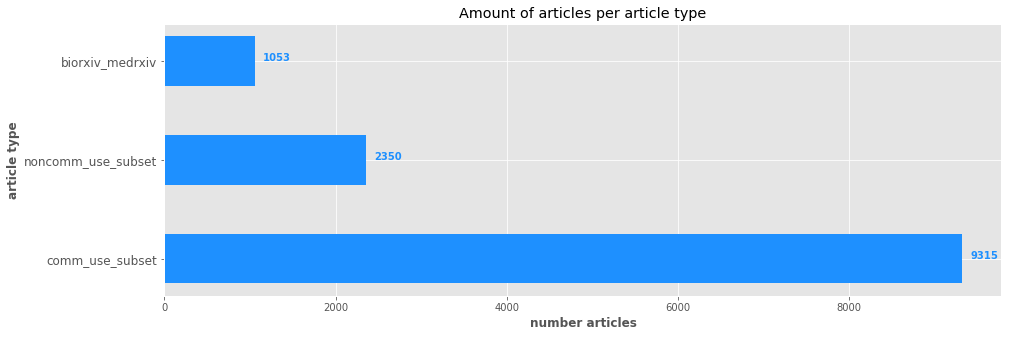

In [8]:
num_articles = df["article type"].value_counts()
y_ticks = ["comm_use_subset", "noncomm_use_subset", "biorxiv_medrxiv"]

fig, ax = plt.subplots(figsize = (15, 5))

width = 0.5      #width of each bar
ind = np.arange(len(num_articles))   # x location
ax.barh(ind, num_articles, width, color = "dodgerblue")
plt.title("Amount of articles per article type")
ax.set_yticks(ind)
ax.set_yticklabels(y_ticks, minor = False, fontsize = 12)
plt.xlabel("number articles", fontweight = "bold")
plt.ylabel("article type", fontweight = "bold")


for i,v in enumerate(num_articles):
    ax.text(v + 100, i, str(v), fontweight = "bold", color = "dodgerblue")

plt.show()

##### The data consists of three article types, most of which is the commercial use subset with 9315 articles, followed by the noncommercial use subset with a total of 2350 articles and last the biological and medical dataset with 1053 articles. In total there are 12718 articles.

### Lets look at wordcount next:

In [9]:
df_stat = df.copy()

mask = df_stat["full_text"]
mask = mask.apply(lambda x: len(x.split(" ")))

In [10]:
df_stat = df_stat.join(mask, rsuffix = "mask")
df_stat.rename(columns = {"full_textmask" : "word_count"}, inplace = True)
df_stat.head()

,title,abstract,full_text,article type,word_count
0,The RNA pseudoknots in foot-and-mouth disease ...,{'text': 'word count: 194 22 Text word count: ...,"VP3, and VP0 (which is further processed to VP...",biorxiv_medrxiv,1710
1,Analysis Title: Regaining perspective on SARS-...,"{'text': 'During the past three months, a new ...","In December 2019, a novel coronavirus, SARS-Co...",biorxiv_medrxiv,2490
2,Healthcare-resource-adjusted vulnerabilities t...,,The 2019-nCoV epidemic has spread across China...,biorxiv_medrxiv,750
3,"Real-time, MinION-based, amplicon sequencing f...",{'text': 'Infectious bronchitis (IB) causes si...,"Infectious bronchitis (IB), which is caused by...",biorxiv_medrxiv,3959
4,A Combined Evidence Approach to Prioritize Nip...,{'text': 'Nipah Virus (NiV) came into limeligh...,Nipah is an infectious negative-sense single-s...,biorxiv_medrxiv,2392


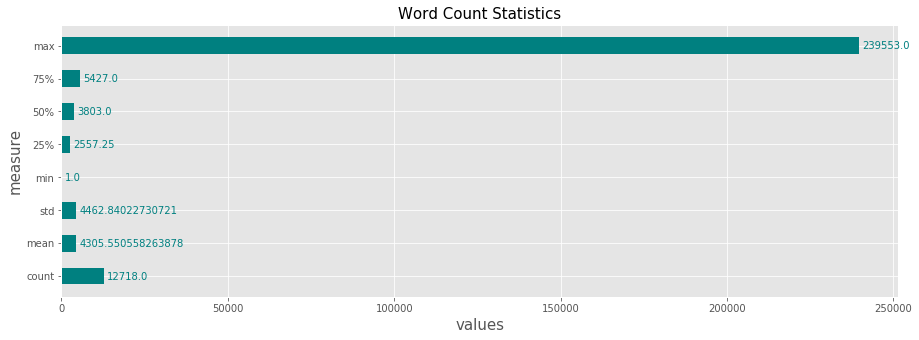

In [11]:
description = df_stat[["word_count"]].describe()

fig, ax = plt.subplots(figsize = (15, 5))

width = 0.5
ind = np.arange(len(description["word_count"]))

ax.barh(ind, description["word_count"], width, color = "teal")
plt.title("Word Count Statistics", fontsize = 15)
plt.xlabel("values", fontsize = 15)
plt.ylabel("measure", fontsize = 15)

ax.set_yticks(ind)
ax.set_yticklabels(description.index)

for i, v in enumerate(description["word_count"]):
    ax.text(v + 1000, i - 0.1, str(v), color = "teal", fontsize = 10)

plt.show()

In [12]:
description.head()

,word_count
count,12718.000000
mean,4305.550558
std,4462.840227
min,1.000000
25%,2557.250000


##### We can see that the longest article consists of up to 239,553 words wheras the shortest only has one word (it seems to be an empty row and we should check it down the line). In the mean the articles are 4305 words long with a total of 12718 articles.

### Word Occurance in Articles, Abstracts and Titles:

In [13]:
from nltk.tokenize import word_tokenize
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\cube\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [14]:
#Get stopwords from WordCloud STOPWORDS and add some more:
stopwords = list(STOPWORDS)
stopwords += "org", "doi", "https", "holder", "perprint", "copyright", "using","preprint","rights","reserved", "peer"
print(len(stopwords))

203


In [15]:
#Word Cloud for full text just for one example text for the moment, since all together is far too many data.
ex_text = df.loc[0,"full_text"]

#Strip stopwords from the text and rejoin to a single string
word_list = word_tokenize(ex_text)
result = [w for w in word_list if not w in stopwords]
result = " ".join(result)
print(result)

VP3 , VP0 ( processed VP2 VP4 virus assembly ) ( 6 ) . The P2 64 P3 regions encode non-structural proteins 2B 2C 3A , 3B ( 1-3 ) ( VPg ) , 3C pro 4 structural protein-coding region replaced reporter genes , allow study genome 68 replication without requirement high containment ( 9 , 10 ) ( figure 1A ) . The FMDV 5′ UTR largest known picornavirus UTR , comprising approximately 1300 71 nucleotides containing several highly structured regions . The first 360 nucleotides 5′ 72 end predicted fold single large stem loop termed S-fragment , followed The PKs originally predicted 1987 consist two four tandem repeats ~48 86 nucleotide region containing small stem loop downstream interaction site ( figure 1B ) 87 ( 12 ) . Due sequence similarity PKs ( figure 1C ) , speculated 88 formed duplication events viral replication , probably involving recombination . 89 Between two four PKs present different virus isolates strain 90 identified less two PKs , emphasising potential importance viral life cyc

### WordCloud for example full text:

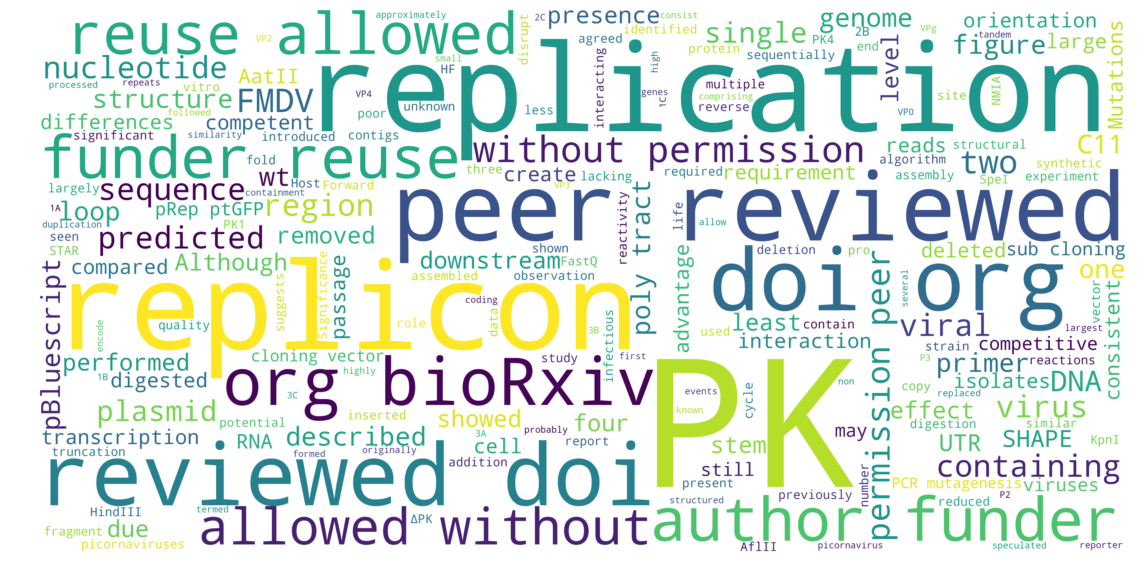

In [16]:
cloud = WordCloud(background_color = "white", width = 5000, height = 2500)
cloud.generate(result)

#Display word cloud
plt.figure(figsize = (20,10))
plt.imshow(cloud, interpolation = "bilinear")
plt.axis("off")
plt.show()

The words found in the WordCloud don't seem to be the ones one would be expecting. This may be due to the fact that we only used one full_text as input.(not representative)

### WordCloud for all abstracts:

In [17]:
#Extract abstract text from abstract dict
wc_df = df.copy()
wc_df["abstract"] = wc_df["abstract"].apply(lambda x: x["text"] if (len(x) > 0) else x)

In [18]:
#Concatenate abstract texts to one single text
abstract_txt = " ".join(wc_df["abstract"])

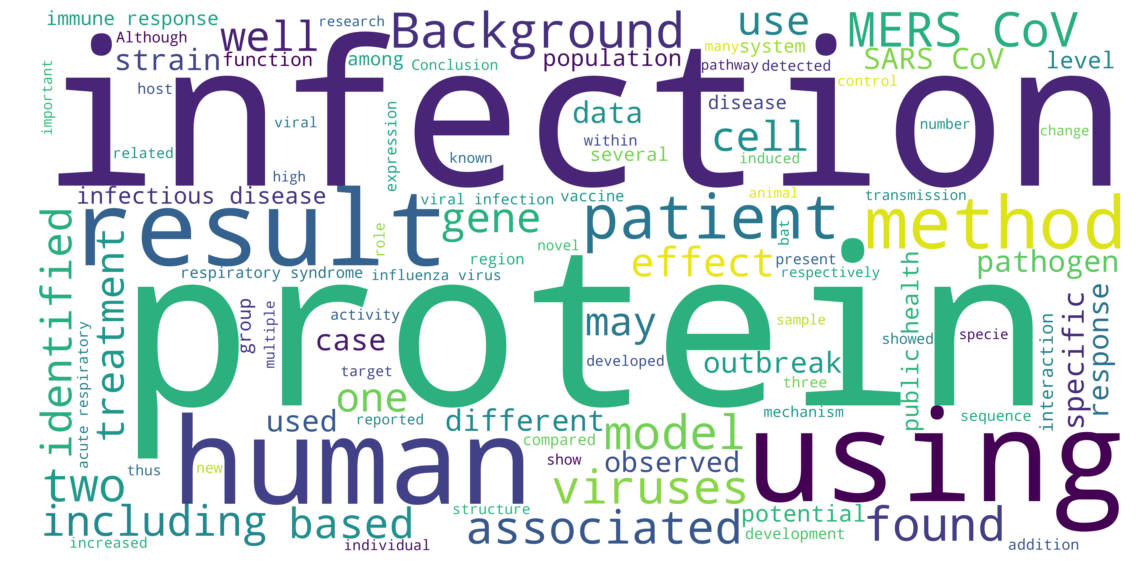

In [19]:
cloud = WordCloud(background_color = "white", width = 5000, height = 2500, max_words = 100)
cloud.generate(abstract_txt)

#Display word cloud
plt.figure(figsize = (20,10))
plt.imshow(cloud, interpolation = "bilinear")
plt.axis("off")
plt.show()

### WordCloud for all Titles:

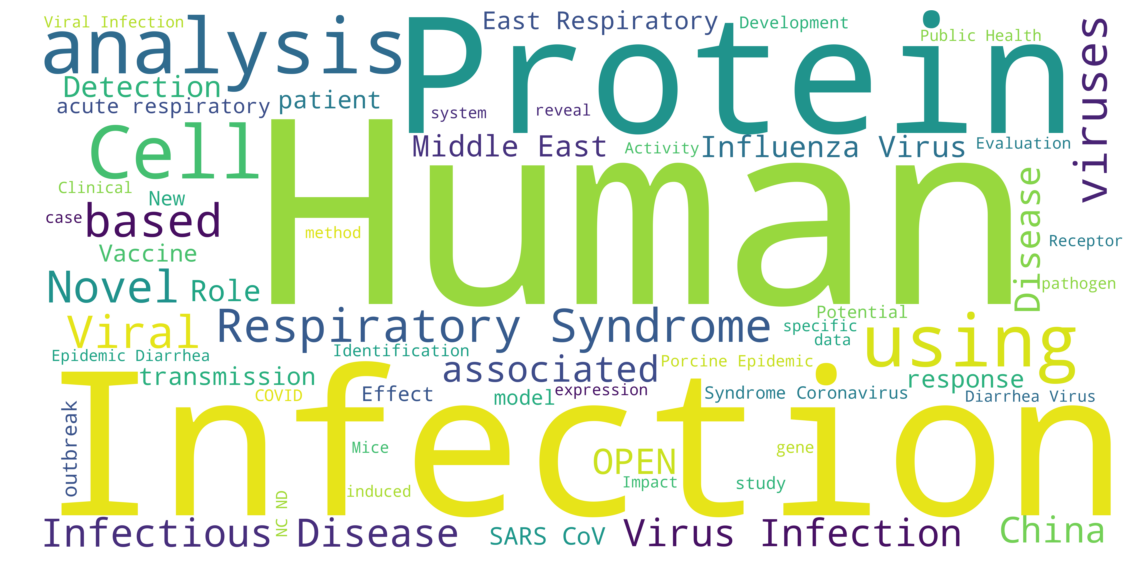

In [20]:
cloud = WordCloud(background_color = "white", width = 5000, height = 2500, max_words = 60)
title_txt = " ".join(wc_df["title"])
cloud.generate(title_txt)

#Display Cloud:
plt.figure(figsize = (20,10))
plt.imshow(cloud, interpolation = "bilinear")
plt.axis("off")
plt.show()

# 2. Topic Modeling:

In [21]:
import nltk; nltk.download("stopwords")

from pprint import pprint

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# spacy for lemmatization
import spacy

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
%matplotlib inline

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\cube\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [22]:
from nltk.corpus import stopwords

In [23]:
stop_words = stopwords.words("english")
print(stop_words)
print(len(stop_words))

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

In [49]:
stop_words.extend(['from', 'subject', 're', 'edu', 'use', "org", "doi", "https", "holder", "perprint", "copyright", "using","preprint","rights","reserved", "peer"])

In [25]:
lda_df = df[df["article type"] == "biorxiv_medrxiv"].copy()
lda_df.head()

,title,abstract,full_text,article type
0,The RNA pseudoknots in foot-and-mouth disease ...,{'text': 'word count: 194 22 Text word count: ...,"VP3, and VP0 (which is further processed to VP...",biorxiv_medrxiv
1,Analysis Title: Regaining perspective on SARS-...,"{'text': 'During the past three months, a new ...","In December 2019, a novel coronavirus, SARS-Co...",biorxiv_medrxiv
2,Healthcare-resource-adjusted vulnerabilities t...,,The 2019-nCoV epidemic has spread across China...,biorxiv_medrxiv
3,"Real-time, MinION-based, amplicon sequencing f...",{'text': 'Infectious bronchitis (IB) causes si...,"Infectious bronchitis (IB), which is caused by...",biorxiv_medrxiv
4,A Combined Evidence Approach to Prioritize Nip...,{'text': 'Nipah Virus (NiV) came into limeligh...,Nipah is an infectious negative-sense single-s...,biorxiv_medrxiv


In [26]:
lda_df.loc[0, "abstract"]

{'text': 'word count: 194 22 Text word count: 5168 23 24 25 author/funder. All rights reserved. No reuse allowed without permission. Abstract 27 The positive stranded RNA genomes of picornaviruses comprise a single large open reading 28 frame flanked by 5′ and 3′ untranslated regions (UTRs). Foot-and-mouth disease virus (FMDV) 29 has an unusually large 5′ UTR (1.3 kb) containing five structural domains. These include the 30 internal ribosome entry site (IRES), which facilitates initiation of translation, and the cis-acting 31 replication element (cre). Less well characterised structures are a 5′ terminal 360 nucleotide 32 stem-loop, a variable length poly-C-tract of approximately 100-200 nucleotides and a series of 33 two to four tandemly repeated pseudoknots (PKs). We investigated the structures of the PKs 34 by selective 2′ hydroxyl acetylation analysed by primer extension (SHAPE) analysis and 35 determined their contribution to genome replication by mutation and deletion experiments

In [27]:
#Abstract is still in dict form. Convert to string:
lda_df["abstract"] = lda_df["abstract"].apply(lambda x: x["text"] if (len(x) > 0) else x)
lda_df.loc[0,"abstract"]

'word count: 194 22 Text word count: 5168 23 24 25 author/funder. All rights reserved. No reuse allowed without permission. Abstract 27 The positive stranded RNA genomes of picornaviruses comprise a single large open reading 28 frame flanked by 5′ and 3′ untranslated regions (UTRs). Foot-and-mouth disease virus (FMDV) 29 has an unusually large 5′ UTR (1.3 kb) containing five structural domains. These include the 30 internal ribosome entry site (IRES), which facilitates initiation of translation, and the cis-acting 31 replication element (cre). Less well characterised structures are a 5′ terminal 360 nucleotide 32 stem-loop, a variable length poly-C-tract of approximately 100-200 nucleotides and a series of 33 two to four tandemly repeated pseudoknots (PKs). We investigated the structures of the PKs 34 by selective 2′ hydroxyl acetylation analysed by primer extension (SHAPE) analysis and 35 determined their contribution to genome replication by mutation and deletion experiments. 36 SHAP

Next we have to get rid of duplicate spaces and convert the data frame to a list in order to preocess it in the next step:

In [28]:
data = lda_df.values.tolist()

Let’s tokenize each sentence into a list of words, removing punctuations and unnecessary characters altogether.

In [29]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(data))

print(data_words[:1])

[['the', 'rna', 'pseudoknots', 'in', 'foot', 'and', 'mouth', 'disease', 'virus', 'are', 'dispensable', 'for', 'genome', 'replication', 'but', 'essential', 'for', 'the', 'production', 'of', 'infectious', 'virus', 'word', 'count', 'text', 'word', 'count', 'author', 'funder', 'all', 'rights', 'reserved', 'no', 'reuse', 'allowed', 'without', 'permission', 'abstract', 'the', 'positive', 'stranded', 'rna', 'genomes', 'of', 'picornaviruses', 'comprise', 'single', 'large', 'open', 'reading', 'frame', 'flanked', 'by', 'and', 'untranslated', 'regions', 'utrs', 'foot', 'and', 'mouth', 'disease', 'virus', 'fmdv', 'has', 'an', 'unusually', 'large', 'utr', 'kb', 'containing', 'five', 'structural', 'domains', 'these', 'include', 'the', 'internal', 'ribosome', 'entry', 'site', 'ires', 'which', 'facilitates', 'initiation', 'of', 'translation', 'and', 'the', 'cis', 'acting', 'replication', 'element', 'cre', 'less', 'well', 'characterised', 'structures', 'are', 'terminal', 'nucleotide', 'stem', 'loop', '

### Feature Engineering:  
##### The next step in preprocessing is building bigram and trigram models. That means finding two, respectively three words, commonly occuring together in the text.  With the gensim phrases model we can do this. Min count and threshold define the difficulty of finding bigrams / trigrams. The higher they are set, the more difficult it is to find matching words.

In [30]:
bigram = gensim.models.Phrases(data_words, min_count = 5, threshold = 100)
trigram = gensim.models.Phrases(bigram[data_words], threshold = 100)

In [31]:
#Reduce sentence to bigrams and trigrams:
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

#Print Example
print(trigram_mod[bigram_mod[data_words[0]]])

['the', 'rna', 'pseudoknots', 'in', 'foot', 'and', 'mouth', 'disease', 'virus', 'are', 'dispensable', 'for', 'genome', 'replication', 'but', 'essential', 'for', 'the', 'production', 'of', 'infectious', 'virus', 'word_count', 'text', 'word_count', 'author', 'funder', 'all', 'rights_reserved_no_reuse', 'allowed_without_permission', 'abstract', 'the', 'positive_stranded', 'rna', 'genomes', 'of', 'picornaviruses', 'comprise', 'single', 'large', 'open_reading_frame', 'flanked', 'by', 'and', 'untranslated_regions_utrs', 'foot', 'and', 'mouth', 'disease', 'virus', 'fmdv', 'has', 'an', 'unusually', 'large', 'utr', 'kb', 'containing', 'five', 'structural', 'domains', 'these', 'include', 'the', 'internal_ribosome_entry', 'site', 'ires', 'which', 'facilitates', 'initiation', 'of', 'translation', 'and', 'the', 'cis', 'acting', 'replication', 'element', 'cre', 'less', 'well', 'characterised', 'structures', 'are', 'terminal', 'nucleotide', 'stem_loop', 'variable', 'length', 'poly_tract', 'of', 'appr

##### Next is building functions for removing stopwords, building bigrams and lemmatizing:

In [32]:
def remove_stop_words(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

In [33]:
def build_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

In [34]:
def build_trigrams(texts):
    return [trigram_mod[doc] for doc in texts]

In [35]:
def lemmatization(texts, allowed_postags = ["NOUN", "ADJ", "VERB", "ADV"]):
    """https://spacy.io/api/annotation"""
    texts_out = []
    
    for sentence in texts:
        doc = nlp(" ".join(sentence))
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    
    return texts_out

##### Next, call the functions sequentially:

In [36]:
# remove stopwords
data_words_nostop = remove_stop_words(data_words)

# build bigrams
data_words_bigrams = build_bigrams(data_words_nostop)

# Initialize spacy en model:
nlp = spacy.load('en', disable=['parser', 'ner'])

# lemmatization, keeping only noun, adj, verb and adverb
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(data_lemmatized[:1])

[['rna', 'pseudoknot', 'foot', 'mouth', 'disease', 'virus', 'dispensable', 'genome', 'replication', 'essential', 'production', 'infectious', 'virus', 'word_count', 'text', 'word_count', 'author', 'funder', 'reuse_allow', 'without_permission', 'abstract', 'positive', 'strand', 'rna', 'genome', 'picornavirus', 'comprise', 'single', 'large', 'open_reading', 'frame', 'flank', 'untranslated_region', 'utrs', 'foot', 'mouth', 'disease', 'virus', 'fmdv', 'unusually', 'large', 'utr', 'contain', 'structural', 'domain', 'include', 'internal_ribosome', 'entry', 'site', 'ir', 'facilitate', 'initiation', 'translation', 'cis', 'act', 'replication', 'element', 'cre', 'less', 'well', 'characterise', 'structure', 'terminal', 'nucleotide', 'stem_loop', 'variable', 'length', 'poly', 'tract', 'approximately', 'nucleotid', 'series', 'tandemly', 'repeat', 'pseudoknot', 'pks', 'investigate', 'structure', 'pks', 'selective', 'hydroxyl', 'acetylation', 'analyse', 'primer_extension', 'shape', 'analysis', 'determ

##### The LDA topic model mainly takes two inputs: A dictionary and the Corpus:

In [37]:
#Dictionary:
id2word = corpora.Dictionary(data_lemmatized)

#Corpus:
texts = data_lemmatized
corpus = [id2word.doc2bow(text) for text in texts]

#print example
print(corpus[:1])

[[(0, 3), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 2), (8, 1), (9, 1), (10, 2), (11, 2), (12, 1), (13, 2), (14, 1), (15, 1), (16, 1), (17, 2), (18, 1), (19, 1), (20, 1), (21, 2), (22, 1), (23, 2), (24, 1), (25, 1), (26, 2), (27, 2), (28, 1), (29, 11), (30, 1), (31, 1), (32, 12), (33, 1), (34, 1), (35, 1), (36, 1), (37, 3), (38, 1), (39, 1), (40, 1), (41, 3), (42, 1), (43, 1), (44, 4), (45, 3), (46, 1), (47, 1), (48, 2), (49, 1), (50, 2), (51, 2), (52, 2), (53, 1), (54, 1), (55, 1), (56, 3), (57, 1), (58, 1), (59, 9), (60, 1), (61, 1), (62, 2), (63, 1), (64, 1), (65, 3), (66, 2), (67, 1), (68, 3), (69, 1), (70, 1), (71, 2), (72, 1), (73, 2), (74, 1), (75, 3), (76, 4), (77, 1), (78, 6), (79, 1), (80, 3), (81, 1), (82, 3), (83, 2), (84, 1), (85, 2), (86, 1), (87, 1), (88, 2), (89, 6), (90, 1), (91, 1), (92, 4), (93, 4), (94, 1), (95, 1), (96, 4), (97, 2), (98, 1), (99, 1), (100, 2), (101, 1), (102, 1), (103, 1), (104, 3), (105, 1), (106, 1), (107, 1), (108, 5), (109, 1), (110, 

The tuple outputs represent the id and frequency for each word in a document.  
To retrieve the corresponding word to an id, just pass the id to the dictionary:

In [38]:
id2word[5]

'achieve'

Apart from that, alpha and eta are hyperparameters that affect sparsity of the topics. According to the Gensim docs, both defaults to 1.0/num_topics prior.

chunksize is the number of documents to be used in each training chunk. update_every determines how often the model parameters should be updated and passes is the total number of training passes.

In [39]:
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=20, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

In [40]:
pprint(lda_model.print_topics())

[(0,
  '0.088*"age" + 0.054*"child" + 0.047*"contact" + 0.034*"group" + '
  '0.032*"social" + 0.019*"female" + 0.018*"sex" + 0.014*"school_closure" + '
  '0.013*"household" + 0.013*"adult"'),
 (1,
  '0.087*"brain" + 0.038*"hippocampus" + 0.031*"seizure" + '
  '0.021*"antipsychotic" + 0.020*"schizophrenia" + 0.016*"axonal" + '
  '0.014*"epilepsy" + 0.012*"heritability" + 0.010*"mr" + 0.010*"cognitive"'),
 (2,
  '0.022*"prediction" + 0.019*"model" + 0.019*"method" + 0.018*"dataset" + '
  '0.017*"predict" + 0.017*"datum" + 0.017*"use" + 0.015*"feature" + '
  '0.013*"network" + 0.013*"base"'),
 (3,
  '0.029*"case" + 0.020*"covid" + 0.020*"license" + 0.019*"number" + '
  '0.019*"epidemic" + 0.016*"china" + 0.013*"wuhan" + 0.013*"confirm" + '
  '0.012*"granted_medrxiv" + 0.012*"display"'),
 (4,
  '0.019*"rna" + 0.014*"sequence" + 0.012*"gene" + 0.009*"fig" + 0.008*"viral" '
  '+ 0.007*"virus" + 0.007*"genome" + 0.007*"read" + 0.006*"identify" + '
  '0.006*"review"'),
 (5,
  '0.065*"cov" + 0.

##### Let us visualize what we have found:

In [41]:
# Visualize the topics
pyLDAvis.enable_notebook()

In [42]:
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)

C:\Users\cube\Anaconda3\lib\site-packages\pyLDAvis\_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


In [43]:
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
4     -0.171755  0.112366       1        1  14.143987
17    -0.189091  0.129636       2        1  13.249394
9     -0.201240 -0.095653       3        1  10.879606
3     -0.205915 -0.185093       4        1   9.265735
11    -0.178964 -0.100369       5        1   8.536410
7     -0.203770 -0.092031       6        1   8.474638
14    -0.197221 -0.174902       7        1   7.330626
6     -0.141826  0.232508       8        1   6.201255
5     -0.163622  0.142944       9        1   5.939086
15    -0.187962  0.047109      10        1   5.770988
10    -0.141506  0.027796      11        1   4.463803
2     -0.076837 -0.021277      12        1   2.683134
18    -0.040624  0.109656      13        1   1.944812
0      0.105692 -0.138175      14        1   0.894539
8      0.336000 -0.001093      15        1   0.118435
1      0.337048  0.001762      16        1   0.061718
13     0.332744  0.000904      17        1   0.027936
19     0.330909  0.001196      18        1   0.007612
16     0.329122  0.001344      19        1   0.005945
12     0.328818  0.001371      20        1   0.000342, topic_info=      Category          Freq             Term         Total  loglift  logprob
489    Default   8283.000000              cov   8283.000000   30.000  30.0000
1676   Default   8819.000000          patient   8819.000000   29.000  29.0000
37     Default  11897.000000             cell  11897.000000   28.000  28.0000
450    Default  13399.000000             case  13399.000000   27.000  27.0000
783    Default   7332.000000              sar   7332.000000   26.000  26.0000
667    Default   8824.000000            model   8824.000000   25.000  25.0000
264    Default   7817.000000          protein   7817.000000   24.000  24.0000
315    Default   6660.000000         sequence   6660.000000   23.000  23.0000
307    Default   4961.000000              rna   4961.000000   22.000  22.0000
490    Default   7255.000000            covid   7255.000000   21.000  21.0000
591    Default   3513.000000            group   3513.000000   20.000  20.0000
782    Default   4506.000000           sample   4506.000000   19.000  19.0000
1026   Default   1858.000000              age   1858.000000   18.000  18.0000
390    Default   8868.000000            virus   8868.000000   17.000  17.0000
1481   Default   2231.000000          contact   2231.000000   16.000  16.0000
550    Default   4367.000000         estimate   4367.000000   15.000  15.0000
590    Default   4946.000000  granted_medrxiv   4946.000000   14.000  14.0000
25     Default   2011.000000            assay   2011.000000   13.000  13.0000
138    Default   5549.000000             gene   5549.000000   12.000  12.0000
149    Default   3406.000000             host   3406.000000   11.000  11.0000
544    Default   4411.000000         epidemic   4411.000000   10.000  10.0000
2259   Default   3668.000000       expression   3668.000000    9.000   9.0000
942    Default   3572.000000       individual   3572.000000    8.000   8.0000
1104   Default   1794.000000        detection   1794.000000    7.000   7.0000
1447   Default   2937.000000             bind   2937.000000    6.000   6.0000
736    Default   3746.000000       population   3746.000000    5.000   5.0000
139    Default   3037.000000           genome   3037.000000    4.000   4.0000
637    Default  10003.000000          license  10003.000000    3.000   3.0000
87     Default   5466.000000          display   5466.000000    2.000   2.0000
845    Default   3916.000000     transmission   3916.000000    1.000   1.0000
...        ...           ...              ...           ...      ...      ...
19953  Topic20      0.000127        nnormally      0.828043    3.804 -10.6747
14412  Topic20      0.000127            carer      0.828043    3.804 -10.6747
14420  Topic20      0.000127      demographie      0.828043    3.804 -10.6747
14419  Topic20      0.000127  demograph

In [52]:
pyLDAvis.display(vis)

##### From these we can deduce topics. e.g.:  
##### 1. Age  
##### 2. Brain  
##### 3. Predictions  
##### 4. Individual Cases etc.
##### We can use these topics to search articles of one specific topic or to filter our data. Further work might be finding the most present topic over all articles or the article fitting a specific topic the best.  But for the while we will leave it at that and proceed to measure the model accuracy. 

## 3. Accuracy Measurment

In [44]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -9.476502920552527

Coherence Score:  0.5051225145893841


### Reading the scores:

#### 1. Perplexity / predictive likelyhood:  
##### Perplexity measures how good a new dataset (article) fits into the predictions. This measurement however has been shown to not closly correlate with human judgment and might even slightly anti correlate. A better measure might therefor be coherence.

#### 2. Topic Coherence:
##### Topic Coherence measuresa topic based on the semantic similarity of its most comon keywords.  Topic Coherence itself is again divided in different sub measures. The one used in this notebook is C_V:  C_V is based on a sliding window, one-set segmentation of the top words and an indirect confirmation measure that uses normalized pointwise mutual information (NPMI) and the cosine similarity

##### A coherence score of 0.50 isn't the best. To improve on this we could try different numbers of topics for the model, just as with a k nearest neighbour model.

# Task Nr.1: Incubation

#### In this section we will try to extract as much information, regarding incubation, as possible out of the full-texts.  Therefor we will parse every sentence and look for any expression containing a number(up to two digits) followed by the keyword "day".  This will result in some false data. We will take care of that along the way.

In [45]:
incubation = df[df["full_text"].str.contains("incubation")]
incubation.reset_index(inplace = True)
incubation.head()

,index,title,abstract,full_text,article type
0,2,Healthcare-resource-adjusted vulnerabilities t...,,The 2019-nCoV epidemic has spread across China...,biorxiv_medrxiv
1,4,A Combined Evidence Approach to Prioritize Nip...,{'text': 'Nipah Virus (NiV) came into limeligh...,Nipah is an infectious negative-sense single-s...,biorxiv_medrxiv
2,9,Carbon Nanocarriers Deliver siRNA to Intact Pl...,{'text': 'Post-transcriptional gene silencing ...,"siRNA without relying on plant transformation,...",biorxiv_medrxiv
3,11,Estimating Preventable COVID19 Infections Rela...,{'text': 'Background: As the number of suspect...,Despite its humble origins as a cluster of cas...,biorxiv_medrxiv
4,12,A hidden gene in astroviruses encodes a cell-p...,{'text': 'Human astroviruses are small nonenve...,Humans astroviruses (HAstVs) belong to genus M...,biorxiv_medrxiv


In [46]:
texts = incubation["full_text"].values

incubation_times = []

for text in texts:
    
    for sentence in text.split(". "):
        
        if "incubation" in sentence:                        
            incubation_time = re.findall(r"\d{1,2} day", sentence)
            
            if len(incubation_time) == 1:
                
                num = incubation_time[0].split(" ")[0]
                
                #if int(num) > 24:
                    #Printing outliers showed that any result for incubation_time over 28 is due to floating numbers.
                    #We will therefor not append them to the list
                    #print(num)
                    #print(sentence)
                    #print
                    
                if int(num) < 29:
                    
                    incubation_times.append(float(num))
                    

In [47]:
incubation_times.sort()
print(incubation_times)
print(len(incubation_times))

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0,

### Lets plot the result to see where we are at:

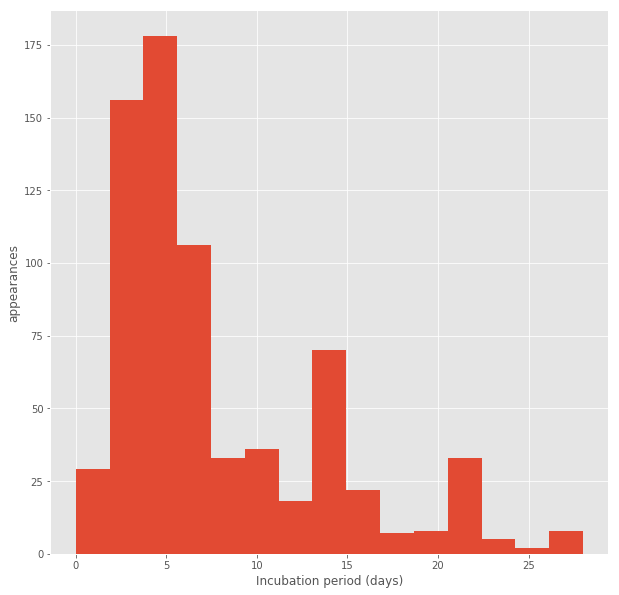

In [48]:
plt.figure(figsize = (10,10))
plt.hist(incubation_times, bins = 15)
plt.ylabel("appearances")
plt.xlabel("Incubation period (days)")
plt.show()